Right click on the shared folder icon, choose -> create shorcut and move it to your MyDrive/ folder

In [1]:
using_colab = True

if using_colab:
    from google.colab import drive
    import torch
    import torchvision

    drive.mount('/content/drive')

    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    !pip install opencv-python matplotlib numpy pandas natsort accelerate
    !pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p data

    !cp "/content/drive/MyDrive/Projekt IO/imagesTr-jpeg.zip" data/
    !cp "/content/drive/MyDrive/Projekt IO/labelsTr-bmp.zip" data/

    !unzip -d data "data/imagesTr-jpeg.zip"
    !unzip -d data "data/labelsTr-bmp.zip"

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/68.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/69.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/70.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/71.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/72.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/73.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/74.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/75.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/76.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/77.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/78.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/79.bmp  
  inflating: data/labelsTr-bmp/BRATS_461/modality_1/scans_y/80.bmp  
  inflating: data/labelsTr-bmp/BRATS_4

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from natsort import natsorted
from PIL import Image

from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
else:
    print("Training should not be done on CPU")

using device: cuda


In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
#match the videos to labels (i could have been done blindly without dataframe)
#but this ensures that all the files are present and is more maintainable
import pandas as pd
# Define directories
video_dir = "/content/data/imagesTr-jpeg"
masks_dir = "/content/data/labelsTr-bmp"

# Initialize an empty DataFrame
train_df = pd.DataFrame(columns=["image", "annotation"])

# Loop through each patient directory (e.g., BRATS_001, BRATS_002)
for image_id in os.listdir(video_dir):
    image_path = os.path.join(video_dir, image_id)
    label_path = os.path.join(masks_dir, image_id, "modality_1")

    # Ensure both image and label directories exist for the patient
    if not os.path.isdir(image_path) or not os.path.isdir(label_path):
        continue

    # Loop through modalities (from modality_1 to modality_4)
    for modality in range(1, 5):
        modality_dir = f"modality_{modality}"
        modality_path = os.path.join(image_path, modality_dir)

        # Check if modality path exists in images
        if not os.path.isdir(modality_path):
            continue

        # Loop through each scan axis (x, y, z)
        for axis in ['x', 'y', 'z']:
            image_scan_path = os.path.join(modality_path, f"scans_{axis}")
            label_scan_path = os.path.join(label_path, f"scans_{axis}")

            # Only add the row if both image and label paths exist
            if os.path.exists(image_scan_path) and os.path.exists(label_scan_path):
                # Create a temporary DataFrame for the new row
                new_row = pd.DataFrame({
                    "image": [image_scan_path],
                    "annotation": [label_scan_path]
                })

                # Concatenate the new row to the main DataFrame
                train_df = pd.concat([train_df, new_row], ignore_index=True)

# Display the first few rows to confirm the structure
print("Training DataFrame:")
print(train_df.head())
print("Total entries in training data:", len(train_df))
data_dir = r"/content/data"
train_df.to_csv(os.path.join(data_dir, "processed_train.csv"), index=False)

Training DataFrame:
                                               image  \
0  /content/data/imagesTr-jpeg/BRATS_473/modality...   
1  /content/data/imagesTr-jpeg/BRATS_473/modality...   
2  /content/data/imagesTr-jpeg/BRATS_473/modality...   
3  /content/data/imagesTr-jpeg/BRATS_473/modality...   
4  /content/data/imagesTr-jpeg/BRATS_473/modality...   

                                          annotation  
0  /content/data/labelsTr-bmp/BRATS_473/modality_...  
1  /content/data/labelsTr-bmp/BRATS_473/modality_...  
2  /content/data/labelsTr-bmp/BRATS_473/modality_...  
3  /content/data/labelsTr-bmp/BRATS_473/modality_...  
4  /content/data/labelsTr-bmp/BRATS_473/modality_...  
Total entries in training data: 5808


In [6]:
def select_random_points(mask, label):
    """
    Function to select random points within the mask for a given label.
    """
    points = np.column_stack(np.where(mask == 1))  # Find the points where mask is 1
    num_points = len(points)

    if num_points == 0:
        return [], []  # No points found, so returning empty lists

    selected_indices = np.random.choice(num_points, size=min(1, num_points), replace=False)
    selected_points = points[selected_indices]

    points = [[x, y] for x, y in selected_points]
    labels = [label for _ in selected_points]
    return points, labels

In [7]:
def read_batch(data):
    """
    For a given index, load the image and its corresponding mask and points.
    """
    ent = data.iloc[np.random.randint(len(data))]

    # Construct paths for the image and corresponding mask frames
    img_dir = ent["image"]
    mask_dir = ent["annotation"]

    # Load all frame files in the folder and sort by filename
    img_frames = natsorted(os.listdir(img_dir))
    msk_frames = natsorted(os.listdir(mask_dir))

    # Strip extensions to find matching base filenames
    img_basenames = {os.path.splitext(f)[0]: f for f in img_frames}
    mask_basenames = {os.path.splitext(f)[0]: f for f in msk_frames}

    # Find the intersection of base filenames
    matching_frames = natsorted(set(img_basenames.keys()).intersection(mask_basenames.keys()))

    # If no matching frames, return None
    if not matching_frames:
        print(f"Error: No matching frames found in {img_dir} and {mask_dir}")
        return None

    # Initialize lists
    image_frames = []
    mask_frames = []
    random_points_all = []
    labels_for_points = []

    for frame_name in matching_frames:
        img_path = os.path.join(img_dir, (frame_name + ".jpeg"))
        mask_path = os.path.join(mask_dir, (frame_name + ".bmp"))

        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        ann_map = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        if img is None or ann_map is None:
            print(f"Error: Could not read image or mask from path {img_path} or {mask_path}")
            continue

        mask_channel_1 = []
        mask_channel_2 = []
        mask_channel_3 = []

        mask_channel_1.append(np.where(ann_map == 255, 1, 0))
        mask_channel_2.append(np.where(ann_map == 170, 1, 0))
        mask_channel_3.append(np.where(ann_map == 85, 1, 0))

        # Generate random points and labels for each mask channel
        random_points_1, labels_1 = select_random_points(mask_channel_1[-1], 1)
        random_points_2, labels_2 = select_random_points(mask_channel_2[-1], 2)
        random_points_3, labels_3 = select_random_points(mask_channel_3[-1], 3)

        random_points = random_points_1 + random_points_2 + random_points_3
        labels = labels_1 + labels_2 + labels_3

        if len(random_points) != len(labels):
            print("missmatch in the size of points and labels")
            continue  # Skip this frame or handle it differently

        # Combine all random points and labels
        random_points_all.append(random_points)
        labels_for_points.append(labels)

        image_frames.append(img)

        # Combine the masks for the current frame using the given weights
        # we are making sure that data that was used for points creation is the same data in masks_frames
        # in future this wont be needed
        for idx in range(len(mask_channel_1)):
            mask_frame = 255 * mask_channel_1[idx] + 170 * mask_channel_2[idx] + 85 * mask_channel_3[idx]
            mask_frames.append(mask_frame)

    # Convert to numpy arrays
    image_frames = np.array(image_frames)
    mask_frames = np.array(mask_frames)

    # Return image_frames and mask_frames instead of undefined variables
    return image_frames, mask_frames, random_points_all, labels_for_points

In [8]:
def visualize_data(image_frames, mask_frames, random_points_all, labels_for_points, idx=None):
    """
    Visualize an image, its segmentation mask, and the random points.
    """
    if idx is None:
        idx = np.random.randint(len(image_frames))  # Choose a random index if not provided

    dot_size = 5

    # Visualization
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title('Original Image at idx ' + str(idx))
    plt.imshow(image_frames[idx], cmap = 'gray')
    plt.axis('off')

    # Segmentation Mask (binary_mask)
    plt.subplot(1, 3, 2)
    plt.title('Binarized Mask at idx ' + str(idx))
    plt.imshow(mask_frames[idx], cmap='gray')
    plt.axis('off')

    # Mask with Points in Different Colors
    plt.subplot(1, 3, 3)
    plt.title(f'Binarized Mask at idx {idx} with random points')
    plt.imshow(mask_frames[idx], cmap='gray')

    label_color_map = {
        1: 'red',
        2: 'orange',
        3: 'yellow',
        4: 'blue',
        5: 'green',
    }

    label_color_map = {1: 'red', 2: 'orange', 3: 'yellow'}
    for points_idx, point in enumerate(random_points_all[idx]):
        plt.scatter(point[1], point[0], color=label_color_map.get(labels_for_points[idx][points_idx], 'black'), s=dot_size)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

(44, 240, 155, 3)
(44, 240, 155)
44
44


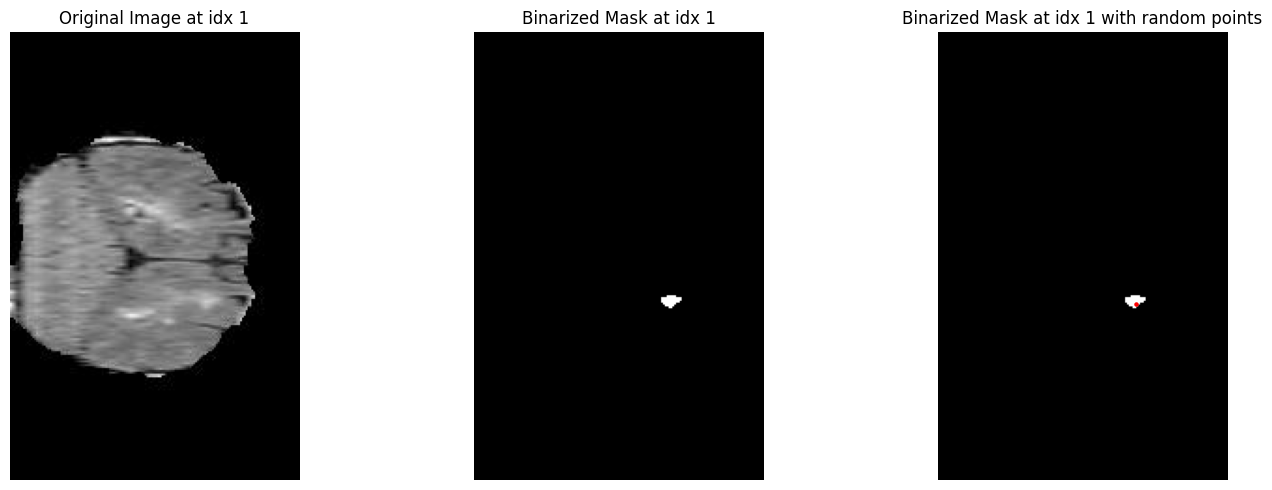

In [9]:
Sanity_check = True
if Sanity_check:
    image_frames, mask_frames, random_points_all, labels_for_points = read_batch(train_df)
    print(image_frames.shape)
    print(mask_frames.shape)
    print(len(random_points_all))
    print(len(labels_for_points))

    visualize_data(image_frames, mask_frames, random_points_all, labels_for_points)

In [10]:
# Define batch size and other configurations
num_epochs = 1
loss_history = []
iou_history = []
FINE_TUNED_MODEL_NAME = "sam_2_fine_tuned_for_brain_tumour_segmentation"

# Move model to GPU
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.to(device)

# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=0.0001, weight_decay=4e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)

scaler = torch.cuda.amp.GradScaler()

# Number of gradient accumulation steps
gradient_accumulation_steps = 16
accumulation_step = 0

In [11]:
torch.cuda.empty_cache()

In [13]:
for itr in range(100):
    with torch.cuda.amp.autocast():
        image_frames, mask_frames, random_points_all, labels_for_points = read_batch(train_df)

        if image_frames is None or mask_frames is None == 0:
            continue

        # Initialize loss accumulator for the batch
        batch_loss = 0.0

        # Loop over each frame in the batch
        for frame_idx, image in enumerate(image_frames):

            # Convert numpy array (H, W, C) to PIL Image
            image_pil = Image.fromarray(image)

            # Now pass the image to the predictor
            predictor.set_image(image_pil)

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                random_points_all[frame_idx], labels_for_points[frame_idx], box=None, mask_logits=None, normalize_coords=True
            )

            # Skip if invalid prompts
            #if unnorm_coords is None or labels[frame_idx] is None:
            #    continue

            with torch.no_grad():
                sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                    points=(unnorm_coords, labels), boxes=None, masks=None
                )

            # Batched mode flag for multi-frame processing
            batched_mode = unnorm_coords.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )

            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
            prd_mask = torch.sigmoid(prd_masks[:, 0])

            # Get the multi-object mask for the current frame
            gt_mask = torch.tensor(mask_frames[frame_idx].astype(np.float32)).cuda()

            seg_loss = (-gt_mask*torch.log(prd_mask+0.00001) - (1-gt_mask)*torch.log((1-prd_mask)+0.00001)).mean()
            inter = (gt_mask.float() * (prd_mask > 0.5).float()).sum()
            union = gt_mask.float().sum() + (prd_mask.float() > 0.5).float().sum().sum() - inter
            iou = inter / (union + 1e-6)  # Avoid division by zero
            score_loss = torch.abs(prd_scores[0] - iou).mean()
            batch_loss = seg_loss + score_loss * 0.05

            del prd_mask, sparse_embeddings, dense_embeddings
            torch.cuda.empty_cache()  # Clear unused memory

        # Mixed precision backpropagation
        optimizer.zero_grad()
        scaler.scale(batch_loss).backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        # Apply gradients every `gradient_accumulation_steps` steps
        if (itr + 1) % gradient_accumulation_steps == 0:
            # Perform optimizer step
            scaler.step(optimizer)
            scaler.update()

        # Update scheduler
        scheduler.step()

        # Save model
        # if itr % 100 == 0:
        #     FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(itr) + ".torch"
        #     torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

        # Update mean IoU for the batch
        #mean_iou = mean_iou * 0.9 + 0.1 * iou.item()

        # Store the loss and IoU for each batch
        loss_history.append(batch_loss)
        iou_history.append(iou)

        # Print progress after each batch
        print(f"iteration {itr}, IoU: {iou:.4f}, Loss: {batch_loss:.4f}")

iteration 0, IoU: 0.0000, Loss: 0.8611
iteration 1, IoU: 0.0000, Loss: 0.3345
iteration 2, IoU: 0.0000, Loss: 0.2136
iteration 3, IoU: 0.0000, Loss: 0.2787
iteration 4, IoU: 0.0000, Loss: 0.3767
iteration 5, IoU: 0.0000, Loss: 0.3748
iteration 6, IoU: 0.0000, Loss: 0.3781
iteration 7, IoU: 0.0000, Loss: 0.4281
iteration 8, IoU: 0.0000, Loss: 0.4061
iteration 9, IoU: 0.0000, Loss: 0.3380
iteration 10, IoU: 0.0000, Loss: 0.7267
iteration 11, IoU: 0.0000, Loss: 1.0266
iteration 12, IoU: 0.0000, Loss: 0.5997
iteration 13, IoU: 1.4976, Loss: -0.0611
iteration 14, IoU: 0.0000, Loss: 0.1537
iteration 15, IoU: 0.0000, Loss: 0.2875
iteration 16, IoU: 0.0000, Loss: 0.3626
iteration 17, IoU: 0.0000, Loss: 0.4005
iteration 18, IoU: 0.0000, Loss: 0.3623
iteration 19, IoU: 0.0000, Loss: 0.4847
iteration 20, IoU: 0.0000, Loss: 0.5849
iteration 21, IoU: 0.0000, Loss: 0.2621
iteration 22, IoU: 0.3618, Loss: 0.1074
iteration 23, IoU: 0.0681, Loss: 0.1778
iteration 24, IoU: 0.0000, Loss: 0.3113
iteration

In [16]:
save_path = 'data/sam_2_fine_tuned_for_brain_tumour_segmentation.pt'


torch.save(predictor.model.state_dict(), save_path)

print(f'Model saved to {save_path}')

Model saved to data/sam_2_fine_tuned_for_brain_tumour_segmentation.pt
